In [2]:
import json
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from IPython.display import display, Markdown
import os

class NotebookOscillator:
    def __init__(self, **kwards):
        self.simulator_path = "./oscillator_simulator"
        self.config = {
            "initial_position": 10.0,
            "initial_velocity": 0.0,
            "dt": 0.001,
            "w": 10.0,
            "gamma": 1.0,
            "omega": 10.0,
            "A": 1.0,
            "simulation_time": 50.0,
            "output_file": "results.csv",
            "method": "RK4",
            "equation": "MathPendulum",
            "m1": 1.0,
            "m2": 1.0,
            "l1": 1.0,
            "l2": 1.0,
            "g": 9.81,
            "theta1": 0,
            "theta2": 0,
            "omega1": 1,
            "omega2": 2
        }
        self.set_parameters(**kwards)
        self.results = None
    
    def compile_simulator(self):
        result = subprocess.run([
            "g++", "-std=c++17", "-O3", "oscillator.cpp", 
            "-o", self.simulator_path
        ], capture_output=True, text=True)
        
        if result.returncode == 0:
            display(Markdown("Симулятор успешно скомпилирован!"))
            return True
        else:
            display(Markdown("Ошибка компиляции:"))
            print(result.stderr)
            return False
    
    def set_parameters(self, **kwargs):
        for key, value in kwargs.items():
            if key in self.config:
                self.config[key] = value
    
    def show_parameters(self):
        display(Markdown("Текущие параметры симуляции"))
        params_df = pd.DataFrame([self.config])
        display(params_df)
    
    def run_simulation(self, config_file="config.json"):
        # Проверяем наличие симулятора
        if not os.path.exists(self.simulator_path):
            if not self.compile_simulator():
                return False
        
        # Сохраняем конфигурацию
        with open(config_file, 'w') as f:
            json.dump(self.config, f, indent=2)
                
        # Запускаем симуляцию
        result = subprocess.run([
            self.simulator_path, config_file
        ], capture_output=True, text=True)
        
        if result.returncode == 0:
            output_file = self.config["output_file"]
            df = pd.read_csv(output_file)
            self.results = df
            return True
        else:
            display(Markdown("Ошибка симуляции:"))
            print(result.stderr)
            return False
        
    
    def plot_results(self):                
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Положение от времени
        ax1.plot(self.results['time'], self.results['position'], 'b-', linewidth=2, label= self.config['method'])
        ax1.set_xlabel('Время (с)')
        ax1.set_ylabel('Положение')
        ax1.set_title('Положение от времени')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Скорость от времени
        ax2.plot(self.results['time'], self.results['velocity'], 'r-', linewidth=2, label= self.config['method'])
        ax2.set_xlabel('Время (с)')
        ax2.set_ylabel('Скорость')
        ax2.set_title('Скорость от времени')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Фазовый портрет
        ax3.plot(self.results['position'], self.results['velocity'], 'g-', linewidth=1, label= self.config['method'])
        ax3.set_xlabel('Положение')
        ax3.set_ylabel('Скорость')
        ax3.set_title('Фазовый портрет')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        
        # Энергия
        ax4.plot(self.results['time'], self.results['energy'], 'purple', linewidth=2, label= self.config['method'])
        ax4.set_xlabel('Время (с)')
        ax4.set_ylabel('Энергия')
        ax4.set_title('Сохранение энергии')
        ax4.grid(True, alpha=0.3)
        ax4.legend()

    def theory_solution(self):
        w = self.config['w']
        gamma = self.config['gamma']
        dt = self.config['dt']
        simulation_time = self.config['simulation_time']
        
        n = int(simulation_time / dt)
        t = np.linspace(0, simulation_time, n)
        
        x = np.zeros(n)
        v = np.zeros(n)
        x_0 = self.config['initial_position']
        v_0 = self.config['initial_velocity']
        
        lambda_1 = 0.5 * (-gamma + np.sqrt(gamma*gamma - 4*w*w))
        lambda_2 = 0.5 * (-gamma - np.sqrt(gamma*gamma - 4*w*w))

        if gamma > 2*w:  # Перезатухание
            for i in range(n):
                c_1 = (v_0 - x_0*lambda_2) / (lambda_1 - lambda_2)
                c_2 = (x_0*lambda_1 - v_0) / (lambda_1 - lambda_2)
                x[i] = c_1*np.exp(lambda_1*t[i]) + c_2*np.exp(lambda_2*t[i])
                v[i] = c_1*lambda_1*np.exp(lambda_1*t[i]) + c_2*lambda_2*np.exp(lambda_2*t[i])
                
        elif gamma == 2*w:  # Критическое затухание
            for i in range(n):
                c_1 = x_0
                c_2 = v_0 + gamma/2 * x_0
                x[i] = (c_1 + c_2*t[i]) * np.exp(-gamma/2 * t[i])
                v[i] = (c_2 * (1 - gamma/2 * t[i]) - c_1 * gamma/2) * np.exp(-gamma/2 * t[i])
                
        else:  # Колебательный случай (γ < 2w)
            beta = np.sqrt(4*w*w - gamma*gamma) / 2
            for i in range(n):
                c_1 = x_0
                c_2 = (v_0 + gamma/2 * x_0) / beta
                x[i] = np.exp(-gamma/2 * t[i]) * (c_1*np.cos(beta*t[i]) + c_2*np.sin(beta*t[i]))
                v[i] = np.exp(-gamma/2 * t[i]) * (
                    -gamma/2 * (c_1*np.cos(beta*t[i]) + c_2*np.sin(beta*t[i])) +
                    beta * (-c_1*np.sin(beta*t[i]) + c_2*np.cos(beta*t[i]))
                )
        E = v**2/2 + w*w*x**2/2
        return x, v, E, t
        
    def compare_methods(self):
        methods = ["RK4", "Euler", "Hoina"]
        colors = ['g', 'r', 'b']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        for i in range(len(methods)):
            self.set_parameters(method=methods[i], output_file=methods[i]+"Results.csv")
            self.run_simulation()

            ax1.plot(self.results['time'], self.results['position'], color=colors[i], linewidth=1, label=methods[i])
            ax2.plot(self.results['time'], self.results['velocity'], color=colors[i], linewidth=1, label=methods[i])
            ax3.plot(self.results['position'], self.results['velocity'], color=colors[i], linewidth=1, label=methods[i])
            ax4.plot(self.results['time'], self.results['energy'], color=colors[i], linewidth=1, label=methods[i])
        
        x_theory, v_theory, E_theory, t_theory = self.theory_solution()
        
        ax1.plot(t_theory, x_theory, color='orange', linewidth=1, label="theory solve")
        ax2.plot(t_theory, v_theory, color='orange', linewidth=1, label="theory solve")
        ax3.plot(x_theory, v_theory, color='orange', linewidth=1, label="theory solve")
        ax4.plot(t_theory, E_theory, color='orange', linewidth=1, label="theory solve")

        ax1.set_xlabel('Время (с)')
        ax1.set_ylabel('Положение')
        ax1.legend()
        ax1.set_title('Положение от времени')
        ax1.grid(True, alpha=0.3)
        
        ax2.set_xlabel('Время (с)')
        ax2.set_ylabel('Скорость')
        ax2.set_title('Скорость от времени')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        ax3.set_xlabel('Положение')
        ax3.set_ylabel('Скорость')
        ax3.set_title('Фазовый портрет')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        
        ax4.set_xlabel('Время (с)')
        ax4.set_ylabel('Энергия')
        ax4.set_title('Сохранение энергии')
        ax4.grid(True, alpha=0.3)
        ax4.legend()

        plt.tight_layout()
        plt.show()
        
    def period(self):
        N = int(self.config['simulation_time'] / self.config['dt'])
        x = np.array(self.results['position'])
        t = np.array(self.results['time'])
        t_1 = 0
        t_2 = 0
        for i in range(N-1,1,-1):
            if (t_1 ==0):
                if (x[i] > 0) and (x[i-1] < 0):
                    t_1 = (t[i]+t[i-1])/2
                elif (x[i] < 0) and (x[i-1] > 0):
                    t_1 = (t[i]+t[i-1])/2
            else:
                if (x[i] > 0) and (x[i-1] < 0):
                    t_2 = (t[i]+t[i-1])/2
                elif (x[i] < 0) and (x[i-1] > 0):
                    t_2 = (t[i]+t[i-1])/2
            if ((t_1 - t_2) != t_1):
                return (t_1-t_2)*2
        display(Markdown("Ошибка расчета периода"))
        return 0   
    
    def fft(self):
        
        # Get the position data and time array
        position_data = self.results['position']
        time_data = self.results['time']
        
        # Compute FFT
        fft_result = np.fft.fft(position_data)
        
        # Calculate frequencies (x-axis for FFT plot)
        sampling_rate = 1 / (time_data[1] - time_data[0])  # Assuming uniform sampling
        freqs = np.fft.fftfreq(len(position_data), 1/sampling_rate)
        
        # Plot magnitude spectrum (usually what we want for FFT)
        plt.figure(figsize=(10, 6))
        plt.plot(freqs[:len(freqs)//2], np.abs(fft_result[:len(fft_result)//2]))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title('FFT of Position Data')
        plt.grid(True)
        plt.show()


    def AFC(self, max_omega: float, domega: float) -> tuple:
        simulation_time = self.config['simulation_time']
        dt = self.config['dt']
        N = int(simulation_time / dt)
        n_points = int(max_omega / domega)
        
        omegas = np.zeros(n_points)
        amplitudes = np.zeros(n_points)
        
        valid_points = 0
        
        for i in range(n_points):
            current_omega = i * domega
            try:
                #выставление параметров
                self.set_parameters(omega=float(current_omega))
                self.run_simulation()

                #расчет периода и проверка, что он положительный
                T = self.period()
                if T <= 0:
                    print(f"Предупреждение: некорректный период для omega={current_omega}")
                    continue
                n_T = int(T / dt)

                #точки для нахождения амплитуды
                x = np.array(self.results['position'])[max(0, N - n_T): N-1]
                if len(x) == 0:
                    print(f"Предупреждение: недостаточно данных для omega={current_omega}")
                    continue
                
                #сохранение результатов
                omegas[valid_points] = current_omega
                amplitudes[valid_points] = np.max(np.abs(x))
                valid_points += 1
                
            except Exception as e:
                print(f"Ошибка при omega={current_omega}: {e}")
                continue
        
        #образка данных по нормальным точкамм
        omegas = omegas[:valid_points]
        amplitudes = amplitudes[:valid_points]
        
        if valid_points == 0:
            display(Markdown("**Ошибка:** Не удалось рассчитать АЧХ!"))
            return omegas, amplitudes
        
        # Построение графика
        plt.figure(figsize=(10, 6))
        plt.plot(omegas, amplitudes, 'b-', linewidth=2, label='АЧХ')
        plt.xlabel('Частота, ω')
        plt.ylabel('Амплитуда')
        plt.title('Амплитудно-частотная характеристика')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        return omegas, amplitudes
    
    def Animation(self):
        fig, ax = plt.subplots()
        xdata, ydata = [], []
        line = ax.plot(xdata, ydata, 'r-')
        def update(frame):
            xdata.append(frame)
            ydata.append(np.sin(frame))
            line.set_data(xdata, ydata)
            ax.relim()
            ax.autoscale_view()
            return line,
    
        plt.show()
        ani = animation.FuncAnimation(fig, update, frames=np.arange(0, 2*np.pi, 0.1), interval=100)

            

In [3]:
sim = NotebookOscillator()
sim.compile_simulator()

Симулятор успешно скомпилирован!

True

In [ ]:
import pygame
import numpy as np
import sys

# Ваш код симуляции
sim.set_parameters(
    simulation_time=100,
    dt=0.01,
    equation="DoublePendulum",
    method="RK4",
    m1=1,
    m2=1,
    l1=1,
    l2=1,
    g=9.81,
    omega2=0,
    theta1=np.pi/2,
    omega1=0,
    theta2=np.pi/2,
    A=10,
    omega=0.1
)
sim.run_simulation()

# Вычисление координат
x_1 = np.sin(sim.results["theta1"])
y_1 = np.cos(sim.results["theta1"])
x_2 = np.sin(sim.results["theta1"]) + np.sin(sim.results["theta2"])
y_2 = np.cos(sim.results["theta1"]) + np.cos(sim.results["theta2"])

# Инициализация Pygame
pygame.init()
width, height = 1000, 1000
screen = pygame.display.set_mode((width, height))
pygame.display.set_caption("Двойной маятник - Pygame")

# Цвета
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
BLACK = (0, 0, 0)

# Масштабирование
scale = 200
center_x, center_y = width // 2, height // 2

# Траектории
trail1 = []
trail2 = []

clock = pygame.time.Clock()
running = True
frame = 0

while running and frame < len(x_1):
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
    
    screen.fill(WHITE)
    
    # Координаты в пикселях
    x1_pix = center_x + int(x_1[frame] * scale)
    y1_pix = center_y + int(y_1[frame] * scale)
    x2_pix = center_x + int(x_2[frame] * scale)
    y2_pix = center_y + int(y_2[frame] * scale)
    
    # Сохраняем траектории
    trail1.append((x1_pix, y1_pix))
    trail2.append((x2_pix, y2_pix))
    
    # Ограничиваем длину траектории
    if len(trail1) > 200:
        trail1.pop(0)
        trail2.pop(0)
    
    # Рисуем траектории
    if len(trail1) > 1:
        pygame.draw.lines(screen, RED, False, trail1, 2)
        pygame.draw.lines(screen, GREEN, False, trail2, 2)
    
    # Рисуем маятник
    pygame.draw.line(screen, BLUE, (center_x, center_y), (x1_pix, y1_pix), 3)
    pygame.draw.line(screen, BLUE, (x1_pix, y1_pix), (x2_pix, y2_pix), 3)
    
    # Рисуем точки
    pygame.draw.circle(screen, RED, (x1_pix, y1_pix), 8)
    pygame.draw.circle(screen, GREEN, (x2_pix, y2_pix), 8)
    pygame.draw.circle(screen, BLACK, (center_x, center_y), 5)
    
    # Время
    font = pygame.font.Font(None, 36)
    time_text = font.render(f"Time: {frame*sim.config["dt"]:.2f}", True, BLACK)
    screen.blit(time_text, (10, 10))
    
    pygame.display.flip()
    clock.tick(60)  # 30 FPS
    frame += 1

pygame.quit()
sys.exit()

SystemExit: 

/home/pipec/Desktop/Subjects/Num_sim/Project_1/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [81]:
sim.set_parameters(
    initial_position=1.0,
    initial_velocity=1.0,
    w=5.0,
    gamma=0.1,
    omega=17.1,
    A=10.0,
    simulation_time=100,
    dt=0.001,
    equation="Pendulum",
    method="RK4_test",
    m1=1,
    m2=1,
    l1=1,
    l2=1,
    g=9.81
)
sim.show_parameters()

Текущие параметры симуляции

,initial_position,initial_velocity,dt,w,gamma,omega,A,simulation_time,output_file,method,equation,m1,m2,l1,l2,g
0,1.0,1.0,0.001,5.0,0.1,17.1,10.0,100,results.csv,RK4_test,Pendulum,1,1,1,1,9.81


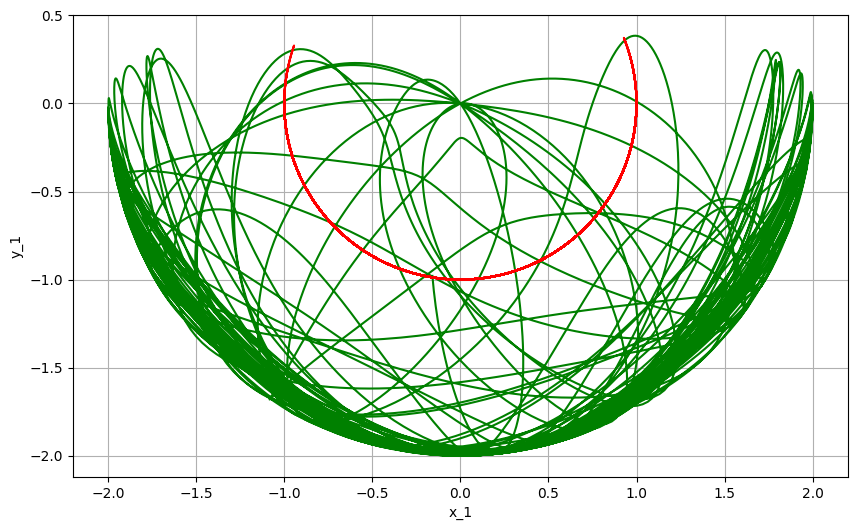

In [17]:
sim.set_parameters(
    simulation_time=100,
    dt=0.01,
    equation="DoublePendulum",
    method="RK4",
    m1=1,
    m2=1,
    l1=1,
    l2=1,
    g=9.81,
    omega2=0,
    theta1=np.pi/2,
    omega1=0,
    theta2=np.pi/2,
    A=10,
    omega=0.1
)
sim.run_simulation()

# Вычисление координат
x_1 = np.sin(sim.results["theta1"])
y_1 = - np.cos(sim.results["theta1"])
x_2 = np.sin(sim.results["theta1"]) + np.sin(sim.results["theta2"])
y_2 = - np.cos(sim.results["theta1"]) - np.cos(sim.results["theta2"])

plt.figure(figsize=(10, 6))
plt.plot(x_2, y_2, 'g')
plt.plot(x_1, y_1, 'r')
plt.xlabel('x_1')
plt.ylabel('y_1')
plt.grid(True)
plt.show()

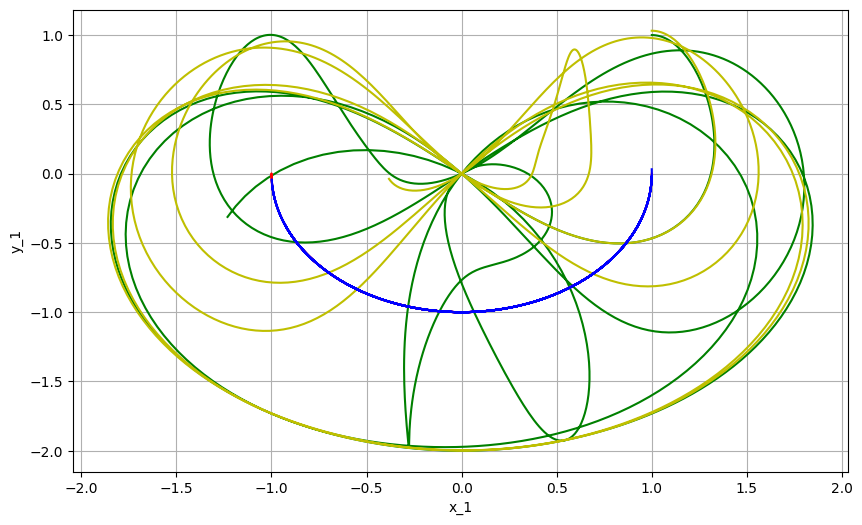

In [247]:
sim.set_parameters(
    simulation_time=10,
    dt=0.01,
    equation="DoublePendulum",
    method="RK4",
    m1=3,
    m2=1,
    l1=1,
    l2=1,
    g=9.81,
    omega2=1,
    theta1=np.pi/2
)
sim.run_simulation()
x_1 = np.sin(sim.results["theta1"])
y_1 = - np.cos(sim.results["theta1"])
x_2 = np.sin(sim.results["theta1"]) + np.sin(sim.results["theta2"])
y_2 = - np.cos(sim.results["theta1"]) + np.cos(sim.results["theta2"])
sim.set_parameters(
    simulation_time=10,
    dt=0.01,
    equation="DoublePendulum",
    method="RK4",
    m1=3,
    m2=1,
    l1=1,
    l2=1,
    g=9.81,
    omega2=1,
    theta1=np.pi*0.51
)
sim.run_simulation()
x_12 = np.sin(sim.results["theta1"])
y_12 = - np.cos(sim.results["theta1"])
x_22 = np.sin(sim.results["theta1"]) + np.sin(sim.results["theta2"])
y_22 = - np.cos(sim.results["theta1"]) + np.cos(sim.results["theta2"])
plt.figure(figsize=(10, 6))
plt.plot(x_2, y_2, 'g')
plt.plot(x_1, y_1, 'r')
plt.plot(x_22, y_22, 'y')
plt.plot(x_12, y_12, 'b')
plt.xlabel('x_1')
plt.ylabel('y_1')
plt.grid(True)
plt.show()

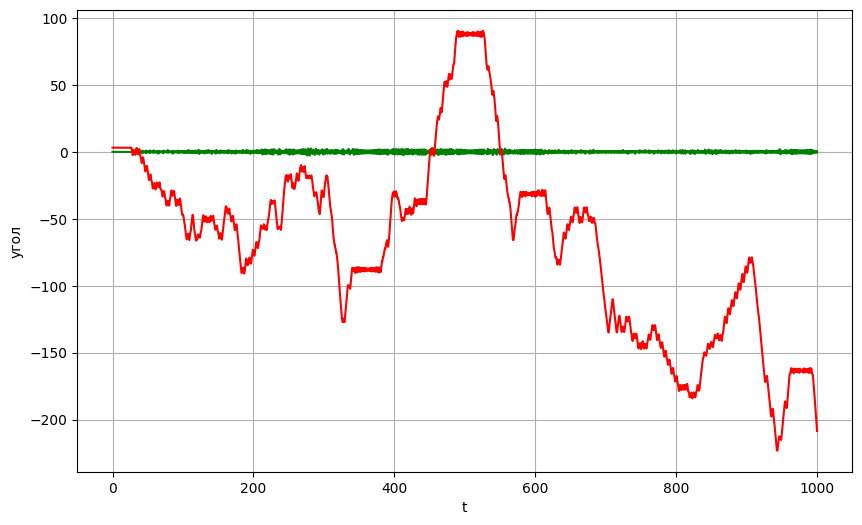

<function matplotlib.pyplot.show(close=None, block=None)>

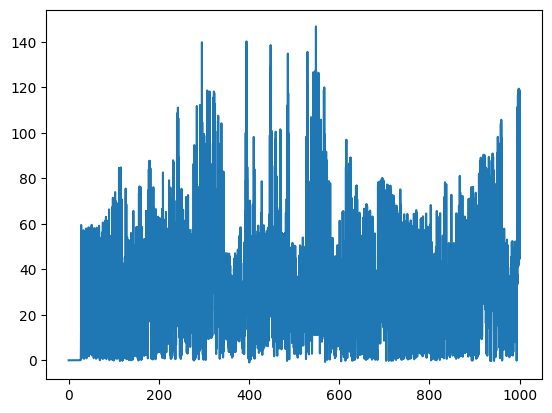

In [249]:
sim.set_parameters(
    simulation_time=1000,
    dt=0.01,
    equation="DoublePendulum",
    method="RK4",
    m1=1,
    m2=1,
    l1=1,
    l2=1,
    g=9.81,
    omega2=0,
    theta1=0,
    omega1=0,
    theta2=np.pi,
    A=0,
    omega=0.1
)
sim.run_simulation()
theta1 = (sim.results["theta1"])
theta2 = (sim.results["theta2"])
omega1 = sim.results["omega1"]
omega2 = sim.results["omega2"]
t= sim.results["time"]
plt.figure(figsize=(10, 6))
plt.plot(t, theta1, 'g')
plt.plot(t, theta2, 'r')
plt.xlabel('t')
plt.ylabel('угол')
plt.grid(True)
plt.show()
E = omega1**2 + omega2**2 + np.cos(theta1)+ np.cos(theta2)
plt.plot(t, E)
plt.show

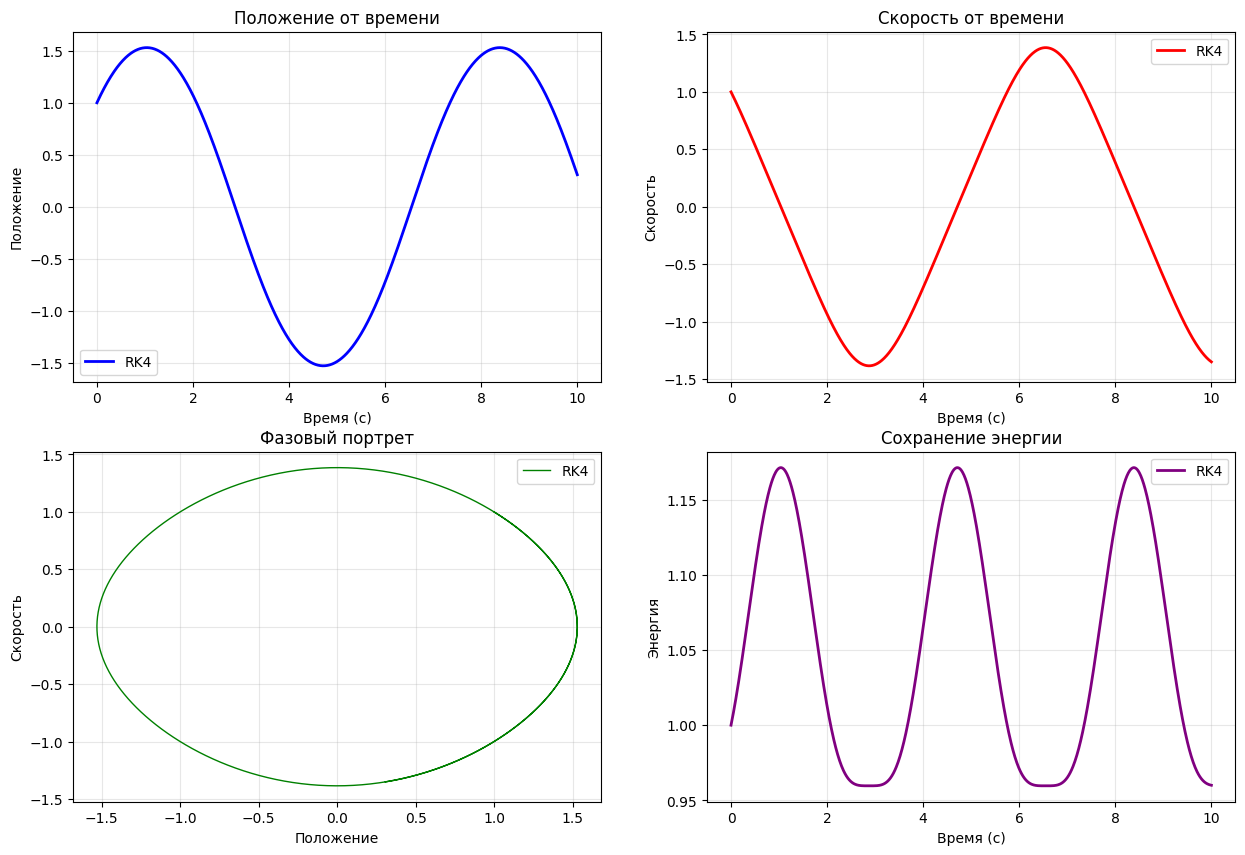

In [118]:
sim.set_parameters(
    initial_position=1.0,
    initial_velocity=1.0,
    w=1.0,
    gamma=0.1,
    omega=17.1,
    A=1000.0,
    simulation_time=10,
    dt=0.01,
    equation="PhysPendulum",
    method="RK4",
    m1=1,
    m2=1,
    l1=1,
    l2=1,
    g=9.81
)
sim.run_simulation()   
sim.plot_results()

Симуляция завершена успешно!

Симуляция завершена успешно!

Симуляция завершена успешно!

/tmp/ipykernel_5309/561735782.py:128: RuntimeWarning: invalid value encountered in sqrt
  lambda_1 = 0.5 * (-gamma + np.sqrt(gamma*gamma - 4*w*w))
/tmp/ipykernel_5309/561735782.py:129: RuntimeWarning: invalid value encountered in sqrt
  lambda_2 = 0.5 * (-gamma - np.sqrt(gamma*gamma - 4*w*w))


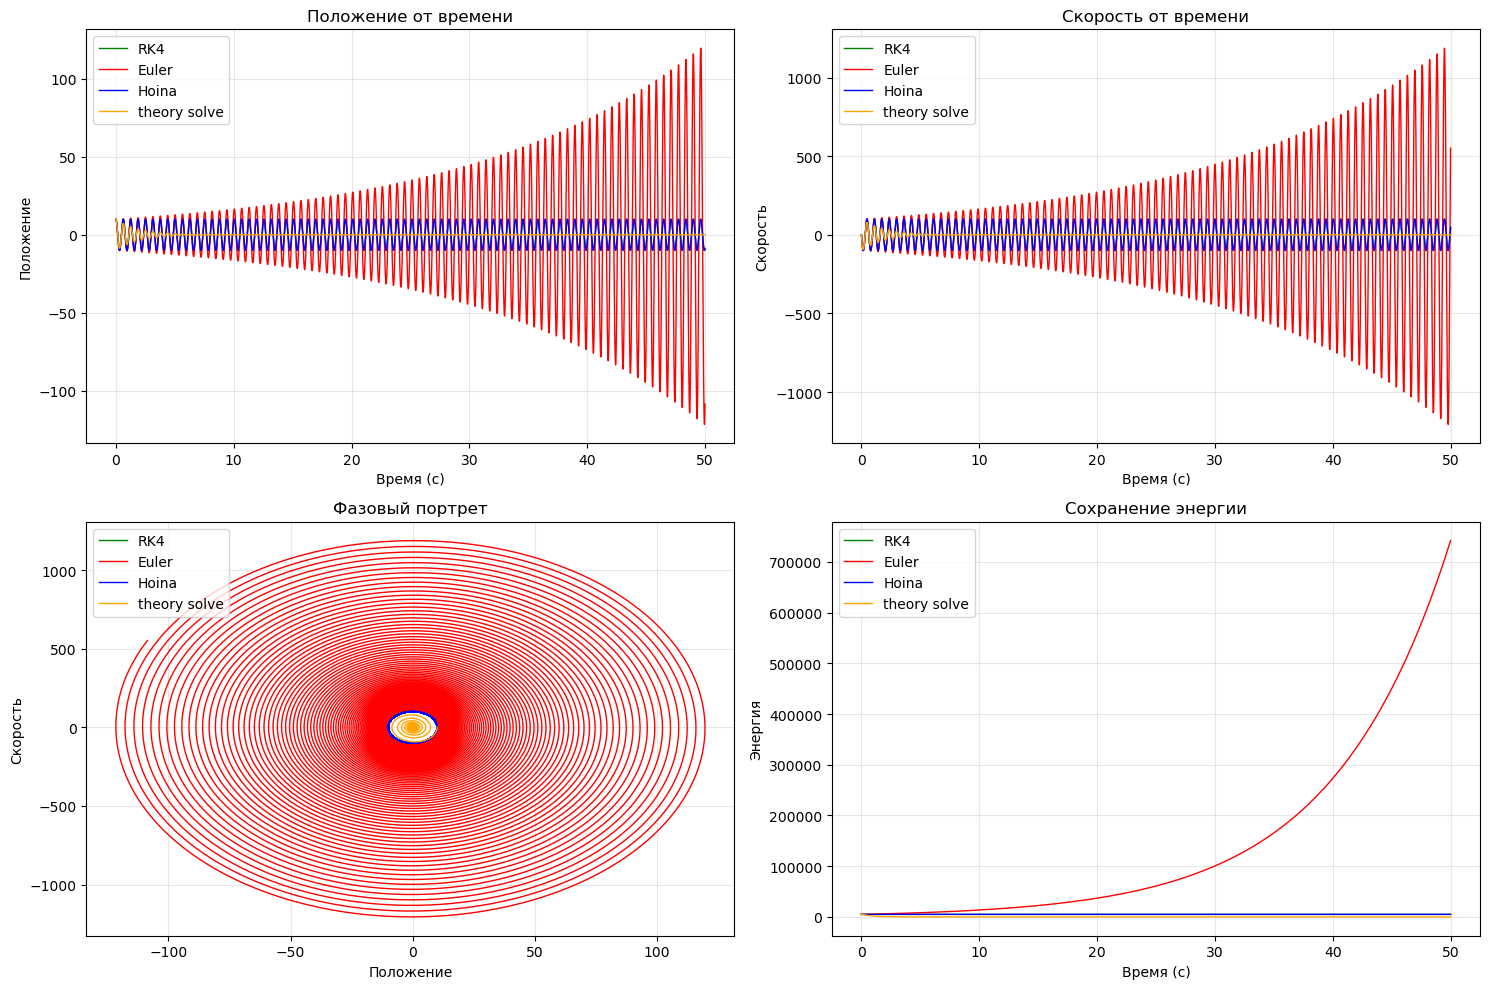

In [81]:
sim.compare_methods()

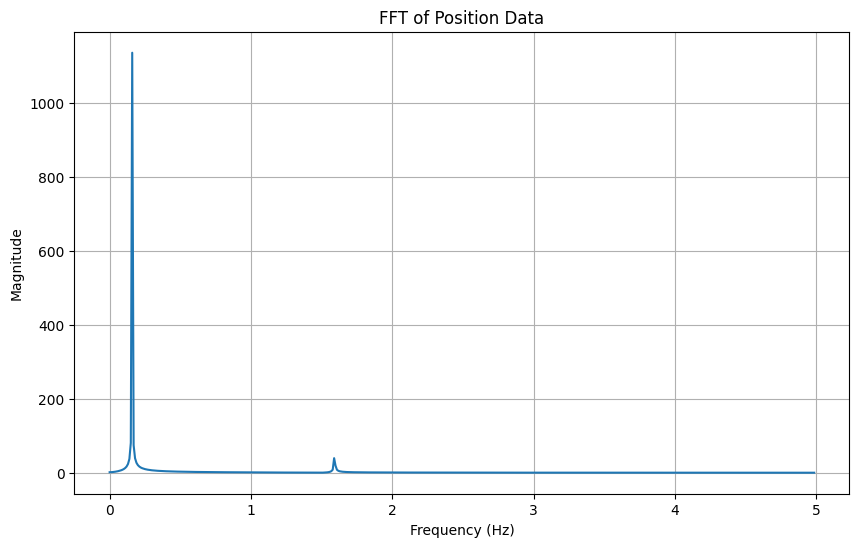

In [30]:
sim = NotebookOscillator()
sim.set_parameters(
    initial_position=1.0,
    initial_velocity=1.0,
    w=1.0,
    gamma=0,
    omega=10,
    A=10.0,
    simulation_time=100,
    dt=0.1,
    equation="ForcedDampedMathPendulum",
    method="RK4"
)
sim.run_simulation()   
sim.fft()